# COMSOL

In [1]:
import os
import sys
sys.path.append('..')

import numpy as np
try:
    import open3d as o3d
except ImportError:
    print(sys.exc_info())
from scipy import interpolate
import quadpy

from dosipy.utils.viz import (set_colorblind, scatter_2d, scatter_3d,
                              fig_config)
from helpers import diff

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# set input data

polarization = 'te'
f = 26
edge_length = 20
area = edge_length ** 2
origin_dict = {'te@26-400': [-25.28, 17.25],
               'tm@26-400': [-19.77, 5.22],
               'te@60-400': [-25.09, 19.09],
               'te@60-100': [-8.5, 11.38],
               'tm@60-400': [-13.24, 13.05],
               'tm@60-100': [-10.32, 13.46]}

In [3]:
# load data

fname = f'APDn_{f}GHz_{polarization.upper()}_{int(area/100)}cm2.txt'
data = np.loadtxt(os.path.join('COMSOL', fname), comments='%')
xyz_rect = data[:, :3] * 1000
APD_rect = data[:, -1]

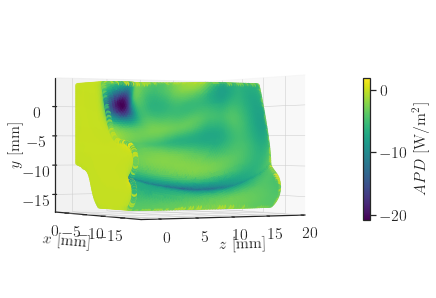

In [4]:
set_colorblind()
label = '$APD$ [W/m$^2$]'
fig_config(latex=True, scaler=1.5, text_size=16)
fig, ax = scatter_3d({'$z$ [mm]': xyz_rect[:, 2],
                      '$x$ [mm]': xyz_rect[:, 0],
                      '$y$ [mm]': xyz_rect[:, 1],
                      label: APD_rect,
                     },
                     elev=[0], azim=[-120],
                    )

In [5]:
# extract points visible from the plane wave incidence POV (-x direction)

pcd_rect = o3d.geometry.PointCloud()
pcd_rect.points = o3d.utility.Vector3dVector(xyz_rect)
center_rect = pcd_rect.get_center()

diameter = np.linalg.norm(
    pcd_rect.get_max_bound() - pcd_rect.get_min_bound()
)
radius = 10 ** 4
camera = [center_rect[0] - diameter, center_rect[1], center_rect[2]]
_, mask = pcd_rect.hidden_point_removal(camera, radius)
xyz_avg = xyz_rect[mask]
APDn = -APD_rect[mask]

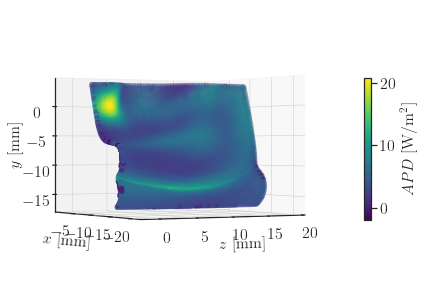

In [6]:
set_colorblind()
label = '$APD$ [W/m$^2$]'
fig_config(latex=True, scaler=1.5, text_size=16)
fig, ax = scatter_3d({'$z$ [mm]': xyz_avg[:, 2],
                      '$x$ [mm]': xyz_avg[:, 0],
                      '$y$ [mm]': xyz_avg[:, 1],
                      label: APDn,
                     },
                     elev=[0], azim=[-120],
                    )

In [7]:
# approximate x = x(y, z) and compute the length of the normal vector

x_fun = interpolate.RBFInterpolator(xyz_avg[:, [2, 1]], xyz_avg[:, 0], neighbors=333)
x_approximate = x_fun(xyz_avg[:, [2, 1]])
np.all(np.isclose(xyz_avg[:, 0], x_approximate))
dxdz = diff(x_fun, arg=0)
dxdy = diff(x_fun, arg=1)
zy = np.c_[xyz_avg[:, 2], xyz_avg[:, 1]]
n_len = np.sqrt(dxdz(zy) ** 2 + dxdy(zy) ** 2 + 1)
mask = np.where(n_len < 10)[0] 

In [8]:
# integrate

degree = 21
values = APDn[mask] * n_len[mask]
bbox = [xyz_avg[mask, 2].min(), xyz_avg[mask, 2].max(),
        xyz_avg[mask, 1].min(), xyz_avg[mask, 1].max()]

func = interpolate.LinearNDInterpolator(zy[mask], values, fill_value=0)

scheme = quadpy.c2.get_good_scheme(degree)
val = scheme.integrate(lambda x: func(x[0], x[1]),
                       quadpy.c2.rectangle_points([xyz_avg[:, 2].min(), xyz_avg[:, 2].max()],
                                                  [xyz_avg[:, 1].min(), xyz_avg[:, 1].max()]))
APD_av = val / area
APD_av

6.862264946730927